# 베어링 수명 예측

In [15]:
import os
from nptdms import TdmsFile

os 모듈은 파일 및 디렉터리 탐색, 경로 조작 등에 사용   
TDMS파일을 다루기 위해 nptdms 패키지에서 TdmsFile 클래스를 가져온다   

TDMS 파일 구조    
File : 최상위 컨테이너   
Group : 채널(Channel)을 논리적으로 묶는 단위   
Channel : 실제 측정 데이터   
Property : 파일/그룹/채널별로 붙일 수 있는 메타데이터   

load_tdms_file 함수는 file_path 경로에 있는 tdms 파일을 읽어 진동데이터와 운전데이터 채널을 반환한다

In [16]:
def load_tdms_file(file_path):
    tdms_file = TdmsFile.read(file_path)
    group_name_vibration = tdms_file.groups()[0].name
    group_name_operation = tdms_file.groups()[1].name
    #tdms 파일 안의 그룹 별 이름을 지정해 주는 것

    vib_channels = tdms_file[group_name_vibration].channels()
    vib_data = {ch.name: ch.data for ch in vib_channels}
    #그룹1(진동 데이터)의 채널과 채널별 데이터 딕셔너리를 만들어준다

    operation_channels = tdms_file[group_name_operation].channels()
    operation_data = {ch.name: ch.data for ch in operation_channels}
    #그룹2(운전 데이터)의 채널과 채널별 데이터 딕셔너리를 만들어준다 

    return vib_data, operation_data

파일 개수 세기, 채널 목록 보기

In [17]:
root_folder = r"C:\Users\paint\OneDrive\Desktop\Train Set"

file_count = 0
all_vib_channels = set()
all_op_channels  = set()
for subdir, dirs, files in os.walk(root_folder):
    #os.walk()으로 sudir에는 '현재 탐색 중인 폴더 경로', dirs에는 그 폴더 안의 하위 폴더 이름 리스트, files에는 그 폴더 안의 파일 이름 리스트를 부여함 
    for file in files:
        if file.endswith(".tdms"):
            #폴더 유형이 .tdms 형식인지 확인하는 작업업
            file_path = os.path.join(subdir, file)
            #하위 모든 폴더의 정확한 경로 지정 
            try:
                vib_data, operation_data = load_tdms_file(file_path)
                file_count += 1
                all_vib_channels.update(vib_data.keys())
                all_op_channels.update(operation_data.keys())
            except Exception as e:
                print(f"❌ 오류 발생: {file_path}")

print(f"\n📦 총 {file_count}개 파일 읽기 완료")
print("  • 진동 데이터 채널 전체 목록:", sorted(all_vib_channels))
print("  • 운전 데이터 채널 전체 목록:", sorted(all_op_channels))


📦 총 1229개 파일 읽기 완료
  • 진동 데이터 채널 전체 목록: ['CH1', 'CH2', 'CH3', 'CH4']
  • 운전 데이터 채널 전체 목록: ['   TC SP Front[℃]', '   TC SP Rear[℃]', '   Torque[Nm]']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

수치 연산을 위한 numpy 라이브러리와 그래프를 그리기 위한 matplotlib 라이브러리의 pyplot 모듈을 불러온다.   
scipy.fft는 푸리에 변환(FFT) 전용 모델이다
고속 푸리에 변환(FFT) 알고리즘과 샘플링 주파수에 대응하는 주파수 벡터를 생성해 주는 유틸리티 함수를 포함한다.   
fft : 시간 신호 데이터를 주파수 스펙드럼으로 변화해주는 함수   
fftfreq : 샘플 개수와 샘플링 간격을 인자로 받아 주파수 벡터를 생성. 주로 fft 결과에 대응하는 x축을 만들 때 사용   

In [19]:
# 시각화할 채널들
channels = ['CH1', 'CH2', 'CH3', 'CH4']

# 샘플링 주파수
fs = 25600  # 25.6kHz

# 시각화할 데이터 길이 (처음 1초 분량만)
duration = 1  # 초
sample_length = int(fs * duration)

시간-진동 플롯 (Time-Domain)   
시간에 따른 실제 데이터 기록을 보여줌

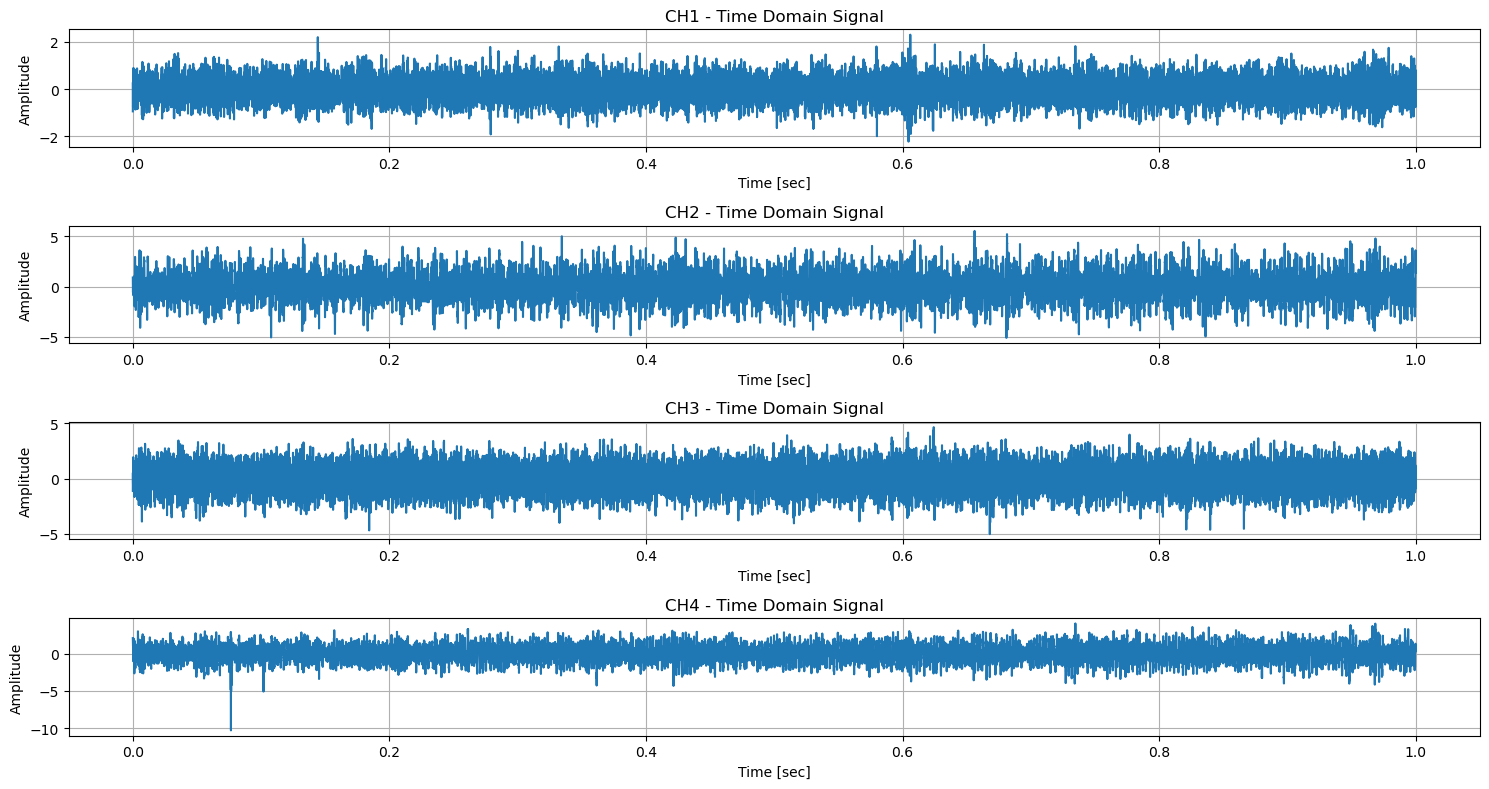

In [20]:
plt.figure(figsize=(15, 8)) #그래프 사이즈

for idx, ch in enumerate(channels):
    plt.subplot(4, 1, idx+1) #4행 1열의 구조 중 idx+1번째 위치에 그래프를 그린다 
    time = np.arange(sample_length) / fs
    plt.plot(time, vib_data[ch][:sample_length]) #반복문 마지막 파일의 값들이 현재 데이터임임
    plt.title(f"{ch} - Time Domain Signal")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude") #진폭 
    plt.grid(True)

plt.tight_layout()
plt.show()


주파수-진동 플롯 (Frequency-Domain, FFT)

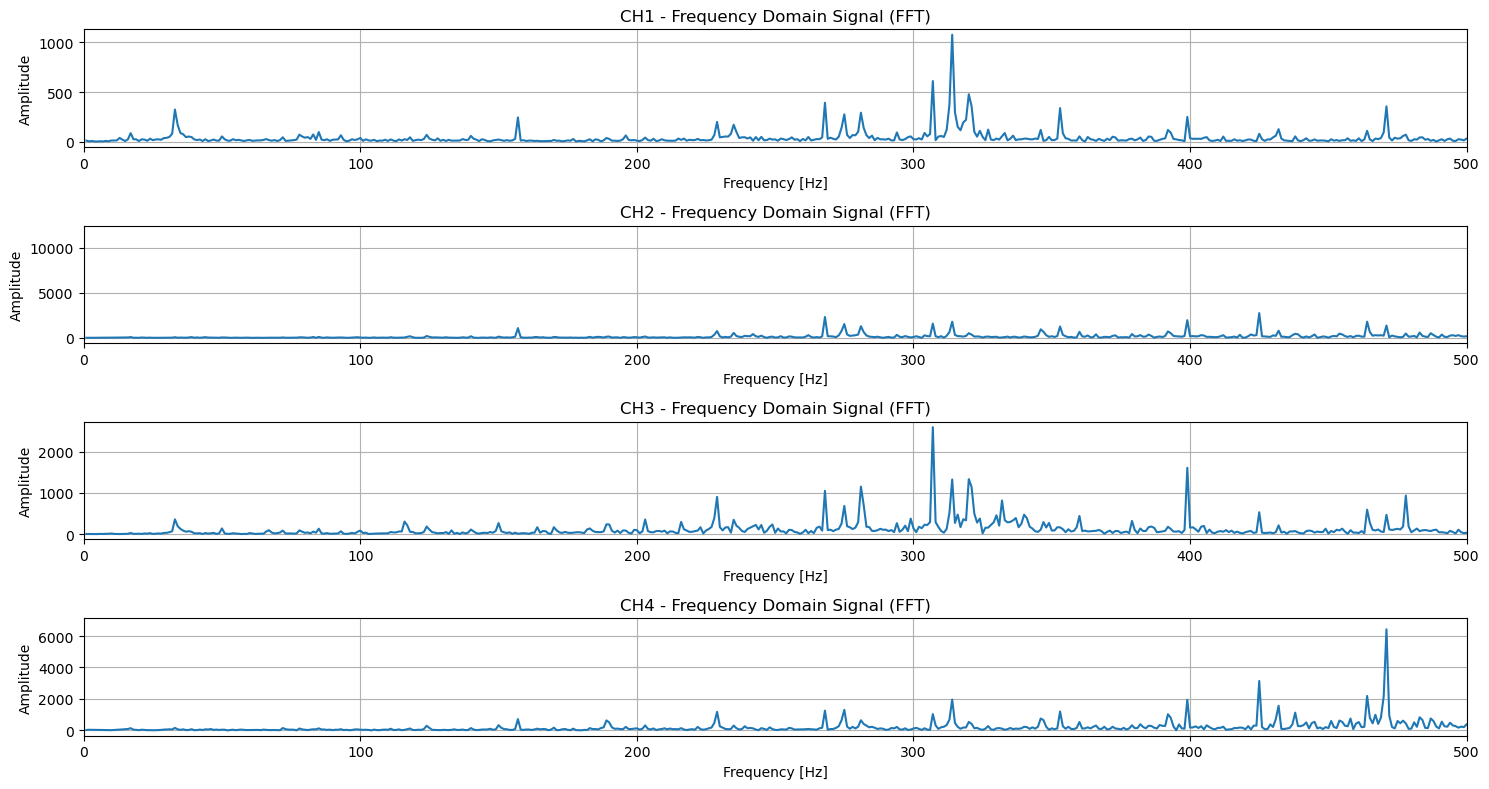

In [21]:
plt.figure(figsize=(15, 8))#그래프 사이즈

for idx, ch in enumerate(channels):
    plt.subplot(4, 1, idx+1)
    # FFT 계산
    yf = fft(vib_data[ch][:sample_length]) #y축 스펙트럼럼
    xf = fftfreq(sample_length, 1/fs) #x축 스펙트럼, N=sample_length, 샘플 간격 d=1/fs
    # 양수 주파수만 선택
    pos_mask = xf > 0
    xf = xf[pos_mask]
    yf = np.abs(yf[pos_mask]) #절댓값
    
    plt.plot(xf, yf)
    plt.title(f"{ch} - Frequency Domain Signal (FFT)")
    plt.xlim(0, 500)  # 0~500Hz 구간만 보기 (고장 주파수 대역)
    plt.xlabel("Frequency [Hz]") #주파수 
    plt.ylabel("Amplitude") #진폭
    plt.grid(True) #눈금

plt.tight_layout()
plt.show()

Bandpass 필터 함수 정의

In [22]:
from scipy.signal import butter, filtfilt
import pandas as pd

def bandpass_filter(data, lowcut=5, highcut=500, fs=25600, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data)
    return filtered

필터링+FFT에너지 추출 

In [84]:
def extract_fft_energy_filtered(vib_data, fs=25600, duration=1.0):
    features={} 
    sample_length = int(fs * duration)

    freq_bands = {
        "BPFI": (135, 145),
        "BPFO": (88, 98),
        "BSF": (73, 83),
        'CRS': (6.2,7.2)
    }

    for ch_name, signal in vib_data.items():
        # 1초만 자르고 필터링
        y_raw = signal[:sample_length]
        y = bandpass_filter(y_raw, lowcut=5, highcut=500, fs=fs)

        # FFT 계산
        yf = np.abs(fft(y))
        xf = fftfreq(sample_length, 1/fs)

        pos_mask = xf > 0
        xf = xf[pos_mask]
        yf = yf[pos_mask]

        for band_name, (f_low, f_high) in freq_bands.items():
            band_mask = (xf >= f_low) & (xf <= f_high)
            energy = np.sum(yf[band_mask]**2)
            features[f"{ch_name}_{band_name}_energy"] = energy

    return features

TDMS 파일에서 진동 채널만 로딩

In [49]:
def load_vibration_only(file_path):
    tdms_file = TdmsFile.read(file_path)
    vib_group = tdms_file.groups()[0].name
    vib_channels = tdms_file[vib_group].channels()
    vib_data = {ch.name.strip(): ch.data for ch in vib_channels}
    return vib_data

전체 폴더에서 feature 추출 

In [50]:
def extract_filtered_features_from_folder(folder_path, fs=25600, duration=1.0):
    all_features = []
    file_count = 0

    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".tdms"):
                file_path = os.path.join(subdir, file)
                try:
                    vib_data = load_vibration_only(file_path)
                    features = extract_fft_energy_filtered(vib_data, fs, duration)
                    features['file'] = file
                    all_features.append(features)
                    file_count += 1

                except Exception as e:
                    print(f"❌ {file} 처리 중 오류: {e}")
    df = pd.DataFrame(all_features)
    df = df.set_index("file")
    print(f"\n📦 총 {file_count}개 파일 처리 완료")
    return df

filtered_feature_df = extract_filtered_features_from_folder(root_folder)
print(filtered_feature_df.head())


📦 총 1229개 파일 처리 완료
                                                    CH1_BPFI_energy  \
file                                                                  
modified_KIMM Simulator_KIMM Bearing Test_20160...     2.290039e+85   
modified_KIMM Simulator_KIMM Bearing Test_20160...     1.725685e+82   
modified_KIMM Simulator_KIMM Bearing Test_20160...     2.261831e+84   
modified_KIMM Simulator_KIMM Bearing Test_20160...     5.261984e+84   
modified_KIMM Simulator_KIMM Bearing Test_20160...     8.926037e+83   

                                                    CH1_BPFO_energy  \
file                                                                  
modified_KIMM Simulator_KIMM Bearing Test_20160...     5.178097e+85   
modified_KIMM Simulator_KIMM Bearing Test_20160...     3.901844e+82   
modified_KIMM Simulator_KIMM Bearing Test_20160...     5.115159e+84   
modified_KIMM Simulator_KIMM Bearing Test_20160...     1.189830e+85   
modified_KIMM Simulator_KIMM Bearing Test_20160...     2

고장 조건 포함된 파일 찾기 

In [ ]:
import os
from nptdms import TdmsFile

def is_failure_file(file_path):
    try:
        tdms_file = TdmsFile.read(file_path)
        op_group = tdms_file.groups()[1].name
        op_channels = tdms_file[op_group].channels()

        # 운전 데이터 추출
        operation_data = {ch.name.strip(): ch.data for ch in op_channels}

        # 값이 1개씩밖에 없으므로 첫 번째 값만 확인
        torque = operation_data['Torque[Nm]'][0]
        temp = operation_data['TC SP Rear[℃]'][0]

        # 고장 조건 체크
        if torque <= -17 or temp >= 200:
            return True  # 고장 조건 포함

    except Exception as e:
        print(f"❌ 오류 발생: {file_path} - {e}")

    return False  # 정상 파일


폴더 전체 돌면서 고장 포함 파일 목록 찾기 

In [71]:
def find_failure_files(folder_path):
    failure_files = []

    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.tdms'):
                file_path = os.path.join(subdir, file)
                if is_failure_file(file_path):
                    failure_files.append(file)

    return sorted(failure_files)

failure_file_list = find_failure_files(root_folder)
print("⚠️ 고장 포함된 파일들:")
for f in failure_file_list:
    print(f)

⚠️ 고장 포함된 파일들:
modified_KIMM Simulator_KIMM Bearing Test_20160326035839.tdms
modified_KIMM Simulator_KIMM Bearing Test_20160416064132.tdms
modified_KIMM Simulator_KIMM Bearing Test_20160420145422.tdms
modified_KIMM Simulator_KIMM Bearing Test_20160529075522.tdms
modified_KIMM Simulator_KIMM Bearing Test_20160609111522.tdms


In [ ]:
from datetime import datetime
# 정확한 고장 파일명과 폴더명 조합으로 RUL 계산 재시도
failure_files = [
    ("modified_KIMM Simulator_KIMM Bearing Test_20160326035839.tdms", "Train1"),
    ("modified_KIMM Simulator_KIMM Bearing Test_20160416064132.tdms", "Train4"),
    ("modified_KIMM Simulator_KIMM Bearing Test_20160420145422.tdms", "Train5"),
    ("modified_KIMM Simulator_KIMM Bearing Test_20160529075522.tdms", "Train7"),
    ("modified_KIMM Simulator_KIMM Bearing Test_20160609111522.tdms", "Train8")
]

# 고장 시각 추출
failure_info = {
    folder: datetime.strptime(filename[-19:-5], "%Y%m%d%H%M%S")
    for filename, folder in failure_files
}

# 전체 파일 탐색 및 RUL 계산
root_folder = r"C:\Users\paint\OneDrive\Desktop\Train Set"
rul_records = []

def extract_timestamp_from_filename(filename):
    m = re.search(r'_(\d{14})\.tdms$', filename)
    if not m:
        return None
    return datetime.strptime(m.group(1), "%Y%m%d%H%M%S")


for subdir, _, files in os.walk(root_folder):
    folder_name = os.path.basename(subdir)
    if folder_name in failure_info:
        failure_time = failure_info[folder_name]
        for file in files:
            if file.lower().endswith(".tdms"):
                file_path = os.path.join(subdir, file)
                start_time = extract_timestamp_from_filename(file)
                if start_time:
                    rul_sec = max(0, (failure_time - start_time).total_seconds())
                    rul_records.append((folder_name, file, start_time, failure_time, rul_sec))

df_rul = pd.DataFrame(rul_records, columns=["Train", "파일명", "측정 시작 시각", "고장 시각", "RUL (초)"])
import pandas as pd

# 1) 날짜 컬럼이 datetime 타입인지 확인 (필요 시)
df_rul['측정 시작 시각'] = pd.to_datetime(df_rul['측정 시작 시각'])
df_rul['고장 시각']     = pd.to_datetime(df_rul['고장 시각'])

# 2) 그룹별 실험 시작 시각(최소), 고장 시점(유일값)을 집계
summary = df_rul.groupby('Train').agg(
    실험_시작_시각 = ('측정 시작 시각', 'min'),
    고장_시점     = ('고장 시각',       'first')
).reset_index()

# 3) 수명(초) 계산
summary['수명 (초)'] = (
    summary['고장_시점'] - summary['실험_시작_시각']
).dt.total_seconds()

# 4) 결과 출력
print(summary.to_string(index=False))


 Train            실험_시작_시각               고장_시점   수명 (초)
Train1 2016-03-25 12:26:39 2016-03-26 03:58:39  55920.0
Train4 2016-04-14 17:51:32 2016-04-16 06:41:32 132600.0
Train5 2016-04-18 19:34:22 2016-04-20 14:54:22 156000.0
Train7 2016-05-27 15:45:22 2016-05-29 07:55:22 144600.0
Train8 2016-06-08 18:45:22 2016-06-09 11:15:22  59400.0
